In [6]:
from sklearn.datasets import load_svmlight_file
train_x, train_y = load_svmlight_file("C:/2023Malgan/Malware-GAN-attack-master/train_data.libsvm",
                                      n_features=3514,
                                      multilabel=False, 
                                      zero_based=False,
                                      query_id=False)
print(train_x.shape)

(13190, 3514)


In [30]:
from sklearn.datasets import load_svmlight_file
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Activation, Maximum
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd

class MalGAN():
    def __init__(self, model_name, apifeature_dims, z_dims, generator_layers, substitute_detector_layers):
        self.model_name = model_name
        self.apifeature_dims = apifeature_dims
        self.z_dims = z_dims
        self.generator_layers = generator_layers
        self.substitute_detector_layers = substitute_detector_layers
        self.blackbox = self.build_blackbox_detector(self.model_name)
        self.generator = self.build_generator()
        self.substitute_detector = self.build_substitute_detector()
        
    def build_substitute_detector(self):
        input = Input(shape=(self.substitute_detector_layers[0],))
        x = input
        for dim in self.substitute_detector_layers[1:]:
            x = Dense(dim)(x)
            x = Activation(activation='sigmoid')(x)
        substitute_detector = Model(input, x, name='substitute_detector')
        substitute_detector.summary()
        return substitute_detector
        
    def build_blackbox_detector(self, model_name):
        if model_name == "RandomForest":
            PATH = "C:/malgagag/MalILVR-master/blackbox/RandomForest.pickle"
        elif model_name == "LogisticRegression":
            PATH = "C:/malgagag/MalILVR-master/blackbox/LogisticRegression.pickle"
        elif model_name == "SupportVectorMachine":
            PATH = "C:/malgagag/MalILVR-master/blackbox/SupportVectorMachine.pickle"
        elif model_name =="DecisionTree":
            PATH="C:/malgagag/MalILVR-master/blackbox/DecisionTree.pickle"

        with open(PATH, 'rb') as file:
            model = pickle.load(file)

        print("모델 로드:", PATH)
        return model

    def train(self, epochs, batch_size):
        model = self.blackbox
        
        
        # TensorFlow 세션 초기화
        sess = tf.compat.v1.Session()
        tf.compat.v1.keras.backend.set_session(sess)

        # Load test dataset (all malware)
        seed_dict = pickle.load(open('feat_dict.pickle', 'rb'), encoding='latin1')
        features = []
        sha1 = []
        dist_dict = {} # [key]: hash [value]: L0 distance
        for key in seed_dict:
            seed_dict[key] = seed_dict[key].toarray()[0]
            features.append(seed_dict[key])
            sha1.append(key)
        feed_feat = np.stack(features)
        xtest_mal, ytest_mal = feed_feat, np.ones(len(feed_feat))

        # Load training dataset
        train_x, train_y = load_svmlight_file("C:/2023Malgan/Malware-GAN-attack-master/train_data.libsvm",
                                              n_features=3514,
                                              multilabel=False, 
                                              zero_based=False,
                                              query_id=False)
        train_x = train_x.toarray()
        xtrain_ben = train_x[6896:]
        ytrain_ben = train_y[6896:]
        xtrain_mal = train_x[0:6896]              
        ytrain_mal = train_y[0:6896]
        
        self.substitute_detector.compile(loss='binary_crossentropy',
                                         optimizer="adam",
                                         metrics=['accuracy'])
        # Since the training dataset is unbalanced, we randomly choose samples from the benign dataset
        # and add them to the end to balance the data
        idx = np.random.randint(0, xtrain_ben.shape[0], 6896 - 6294)
        add_on = xtrain_ben[idx]
        add_on_label = ytrain_ben[idx]
        xtrain_ben = np.concatenate((xtrain_ben, add_on), axis=0)
        ytrain_ben = np.concatenate((ytrain_ben, add_on_label), axis=0)

        Test_TPR = []
       

        for epoch in range(epochs):
        # Each epoch goes through all the data in the training set
            start = 0

        for step in range(xtrain_mal.shape[0] // batch_size):
            xmal_batch = xtrain_mal[start : start + batch_size]
            noise = np.random.uniform(0, 1, (batch_size, self.z_dims))
            xben_batch = xtrain_ben[start : start + batch_size]
            start = start + batch_size
                
            # Predict using the blackbox detector
            yben_batch = model.predict(xben_batch)

            # Generate a batch of new malware examples
            gen_examples = self.generator.predict([xmal_batch, noise])
            ymal_batch = model.predict(np.ones(gen_examples.shape) * (gen_examples > 0.5))

            # Train the substitute_detector
            d_loss_real = self.substitute_detector.train_on_batch(xben_batch, yben_batch)
            d_loss_fake = self.substitute_detector.train_on_batch(gen_examples, ymal_batch)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Define the combined model
            noise = Input(shape=(self.z_dims,))
            example = Input(shape=(self.apifeature_dims,))
            malware = self.generator([example, noise])
            self.substitute_detector.trainable = False
            valid = self.substitute_detector(malware)
            self.combined = Model([example, noise], valid)
            self.combined.compile(loss='binary_crossentropy', optimizer="adam")

            # Train the generator
            noise = np.random.uniform(0, 1, (batch_size, self.z_dims))
            g_loss = self.combined.train_on_batch([xmal_batch, noise], np.zeros((batch_size, 1)))

                

            # After each epoch, evaluate evasion performance on the test dataset
            # Try different noise for 3 times
            for j in range(3):
                noise = np.random.uniform(0, 1, (xtest_mal.shape[0], self.z_dims))
                gen_examples = self.generator.predict([xtest_mal, noise])
                    
                TPR = model.predict(np.ones(gen_examples.shape) * (gen_examples > 0.5))
            
                Test_TPR.append(TPR)
            
                transformed_to_bin = np.ones(gen_examples.shape) * (gen_examples > 0.5)
            
                pred_y_label = model.predict(np.ones(gen_examples.shape) * (gen_examples > 0.5))
                
                # Remove successfully evaded malware examples from xtest_mal
                i = 0
                while i < pred_y_label.shape[0]:
                    if pred_y_label[i] == 0: # should be 1 but predicted as 0
                        L0 = np.sum(transformed_to_bin[i]) - np.sum(xtest_mal[i]) # insertion only
                        dist_dict[sha1[i]] = L0  # [key]: hash [value]: L0 distance
                        xtest_mal = np.delete(xtest_mal, i, 0)
                        pred_y_label = np.delete(pred_y_label, i, 0)
                        sha1 = sha1[:i] + sha1[i+1:]
                    else:
                        i += 1
                print("Remaining malware examples:", xtest_mal.shape[0])
                if xtest_mal.shape[0] == 0:
                    break  # Successfully evaded all

        
            if xtest_mal.shape[0] == 0:
                print("Successfully evaded all malware examples.")
                break

        sess.close()

        ERA = []
        success_num = 0
        # Calculate ERA for each L0 distance
        for i in range(3515):  # 0 - 3514 features
            for key in dist_dict:
                if dist_dict[key] == i:
                    success_num += 1
            ERA.append((3435 - success_num) / 3435)
        
        if ERA[-1] != 0:
            print("{} is not completely evaded after {} epochs. ERA = {}".format(self.model_name, epochs, ERA[-1]))
        if self.model_name == 'RandomForest': curve_name = 'RandomForest'
        if self.model_name == "LogisticRegression": curve_name = 'LogisticRegression'
        if self.model_name == "DecisionTree": curve_name = 'DecisionTree' 
        if self.model_name == "SupportVectorMachine": curve_name = 'SupportVectorMachine'


        model_df = pd.DataFrame(dict(ERA = np.asarray(ERA, dtype=np.float32),\
                                     model = curve_name, L0 = np.arange(3515)))
        return model_df

    def build_generator(self):
        example = Input(shape=(self.apifeature_dims,))
        noise = Input(shape=(self.z_dims,))
        x = Concatenate(axis=1)([example, noise])
        for dim in self.generator_layers[1:]:
            x = Dense(dim)(x)
            x = Activation(activation='sigmoid')(x)
        x = Maximum()([example, x])
        generator = Model([example, noise], x, name='generator')
        return generator

    def predict(self, data):
        model = self.blackbox
        predicted = model.predict(data)
        return predicted


# 블랙박스 모델 이름을 사용하여 MalGAN 객체를 초기화합니다.
malgan = MalGAN("SupportVectorMachine", 
                apifeature_dims=3514, 
                z_dims=100, 
                generator_layers=[3514, 1024, 2048, 4096, 3514], 
                substitute_detector_layers=[3514, 1024, 1])
# or "LogisticRegression", "SupportVectorMachine"

# 학습 데이터 로드
train_x, train_y = load_svmlight_file("C:/2023Malgan/Malware-GAN-attack-master/train_data.libsvm",
                                      n_features=3514,
                                      multilabel=False, 
                                      zero_based=False,
                                      query_id=False)
train_x = train_x.toarray()

# MalGAN을 학습시킵니다.
malgan.train(epochs=50, batch_size=128)

# 샘플 생성
sample_size = 6896
noise = np.random.uniform(0, 1, (sample_size, malgan.z_dims))
generated_samples = malgan.generator.predict([train_x[:sample_size], noise])

# 생성된 샘플을 npy 파일로 저장
np.save("SupportVectorMachine.npy", generated_samples)



모델 로드: C:/malgagag/MalILVR-master/blackbox/SupportVectorMachine.pickle
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_984 (InputLayer)       [(None, 3514)]            0         
_________________________________________________________________
dense_130 (Dense)            (None, 1024)              3599360   
_________________________________________________________________
activation_130 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 1025      
_________________________________________________________________
activation_131 (Activation)  (None, 1)                 0         
Total params: 3,600,385
Trainable params: 3,600,385
Non-trainable params: 0
_________________________________________________________________


C:\Users\HS\AppData\Local\Temp\ipykernel_10480\1361016259.py:55: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  seed_dict = pickle.load(open('feat_dict.pickle', 'rb'), encoding='latin1')


Remaining malware examples: 0
Successfully evaded all malware examples.


모델 로드: C:/malgagag/MalILVR-master/blackbox/LogisticRegression.pickle
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_989 (InputLayer)       [(None, 3514)]            0         
_________________________________________________________________
dense_136 (Dense)            (None, 1024)              3599360   
_________________________________________________________________
activation_136 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 1025      
_________________________________________________________________
activation_137 (Activation)  (None, 1)                 0         
Total params: 3,600,385
Trainable params: 3,600,385
Non-trainable params: 0
_________________________________________________________________


C:\Users\HS\AppData\Local\Temp\ipykernel_10480\1361016259.py:55: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  seed_dict = pickle.load(open('feat_dict.pickle', 'rb'), encoding='latin1')


Remaining malware examples: 0
Successfully evaded all malware examples.
모델 로드: C:/malgagag/MalILVR-master/blackbox/LogisticRegression.pickle
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_994 (InputLayer)       [(None, 3514)]            0         
_________________________________________________________________
dense_142 (Dense)            (None, 1024)              3599360   
_________________________________________________________________
activation_142 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 1025      
_________________________________________________________________
activation_143 (Activation)  (None, 1)                 0         
Total params: 3,600,385
Trainable params: 3,600,385
Non-trainable params: 0
____________________________

C:\Users\HS\AppData\Local\Temp\ipykernel_10480\1361016259.py:55: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  seed_dict = pickle.load(open('feat_dict.pickle', 'rb'), encoding='latin1')


Remaining malware examples: 0
Successfully evaded all malware examples.
모델 로드: C:/malgagag/MalILVR-master/blackbox/LogisticRegression.pickle
Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_999 (InputLayer)       [(None, 3514)]            0         
_________________________________________________________________
dense_148 (Dense)            (None, 1024)              3599360   
_________________________________________________________________
activation_148 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 1025      
_________________________________________________________________
activation_149 (Activation)  (None, 1)                 0         
Total params: 3,600,385
Trainable params: 3,600,385
Non-trainable params: 0
____________________________

C:\Users\HS\AppData\Local\Temp\ipykernel_10480\1361016259.py:55: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  seed_dict = pickle.load(open('feat_dict.pickle', 'rb'), encoding='latin1')


Remaining malware examples: 0
Successfully evaded all malware examples.


NameError: name 'ticker' is not defined

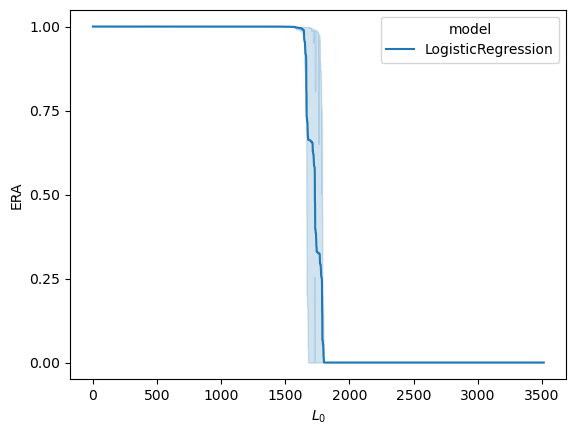

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

models = ["RandomForest", "LogisticRegression", "SupportVectorMachine"] # Define your models list here
dataframes = []

for model in models:
    malgan = MalGAN("LogisticRegression", 
                apifeature_dims=3514, 
                z_dims=100, 
                generator_layers=[3514, 1024, 2048, 4096, 3514], 
                substitute_detector_layers=[3514, 1024, 1])
    df = malgan.train(epochs=50, batch_size=128)
    dataframes.append(df)

data = pd.concat(dataframes, axis=0).reset_index(drop=True)

plt.figure()
g = sns.lineplot(x='L0', y='ERA', data=data, hue='model')
plt.xlabel("$L_0$")
g.set(yticks=[0.00, 0.25, 0.50, 0.75, 1.00])
g.xaxis.set_major_locator(ticker.FixedLocator([10, 200, 500, 1000, 2000, 3514]))
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=labels)
fig = g.get_figure()
fig.savefig("result.png")
plt.show()